<a href="https://colab.research.google.com/github/2303A51780/2303A51780/blob/main/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline


In [2]:
# Load the dataset
car_data = fetch_openml(name='car', version=2, as_frame=True)

# Exploring the dataset
print("Dataset Keys:", car_data.keys())
print("Feature Names:", car_data.feature_names)
print("Target Class Distribution:\n", car_data.target.value_counts())

# Convert to pandas DataFrame
car_df = car_data.frame
print(car_df.head())

# Check data types and shape
print("Data types:\n", car_df.dtypes)
print("Dataset shape:", car_df.shape)


Dataset Keys: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
Feature Names: ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']
Target Class Distribution:
 binaryClass
P    1210
N     518
Name: count, dtype: int64
  buying  maint doors persons lug_boot safety binaryClass
0  vhigh  vhigh     2       2    small    low           P
1  vhigh  vhigh     2       2    small    med           P
2  vhigh  vhigh     2       2    small   high           P
3  vhigh  vhigh     2       2      med    low           P
4  vhigh  vhigh     2       2      med    med           P
Data types:
 buying         category
maint          category
doors          category
persons        category
lug_boot       category
safety         category
binaryClass    category
dtype: object
Dataset shape: (1728, 7)


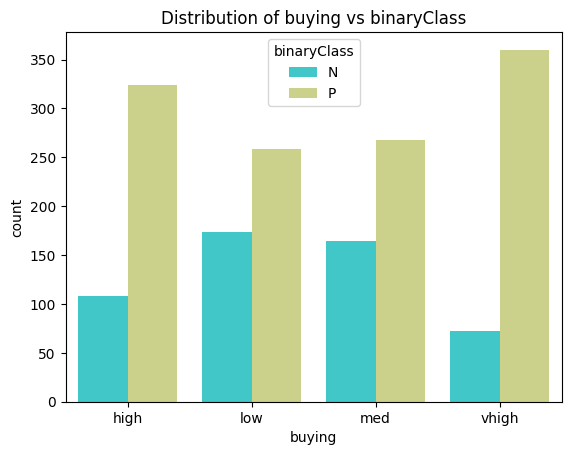

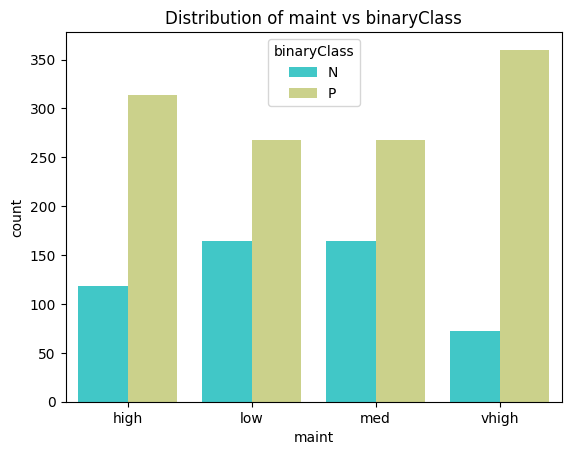

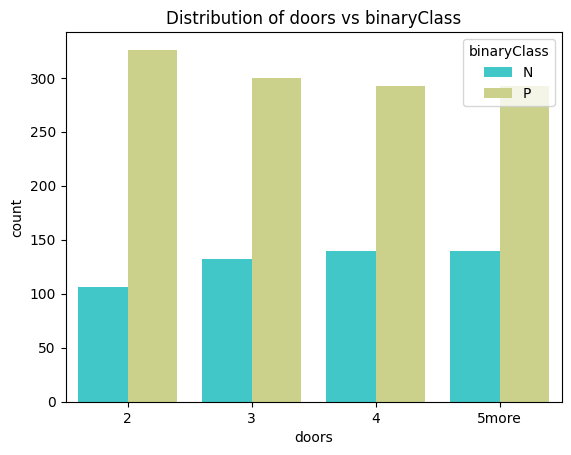

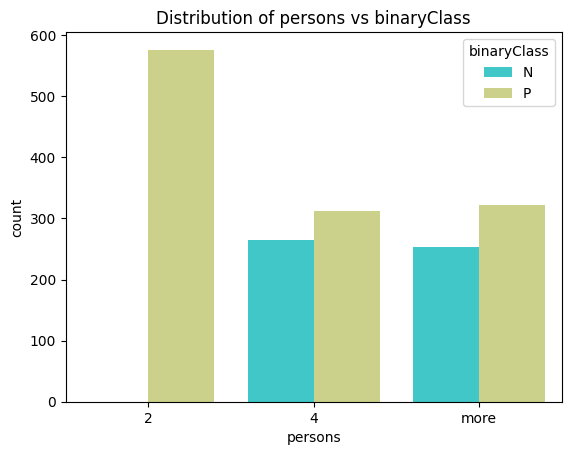

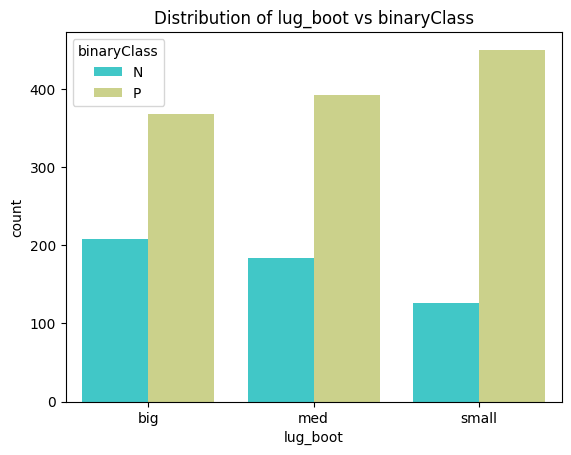

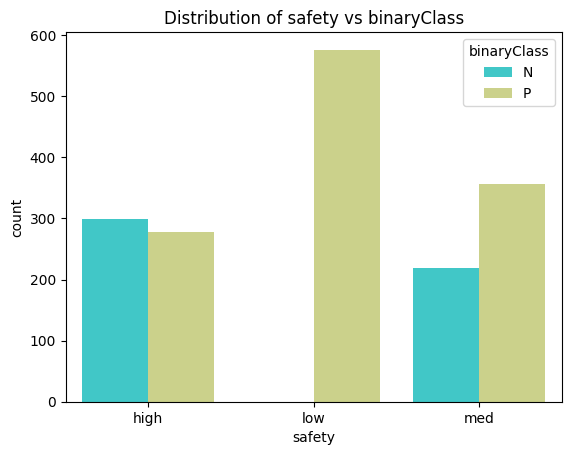

In [3]:
# Visualizing features with respect to target
features = car_data.feature_names
for feature in features:
    sns.countplot(x=feature, hue='binaryClass', data=car_df, palette='rainbow')
    plt.title(f'Distribution of {feature} vs binaryClass')
    plt.show()


In [4]:
# Splitting into training and testing sets
train_data, test_data = train_test_split(car_df, test_size=0.2, random_state=220)

print(f"Dataset size: {car_df.shape[0]}")
print(f"Training set size: {train_data.shape[0]}")
print(f"Testing set size: {test_data.shape[0]}")


Dataset size: 1728
Training set size: 1382
Testing set size: 346


In [5]:
# Separate features and labels
car_train = train_data.drop('binaryClass', axis=1)
car_labels = train_data['binaryClass']

# Pipeline for encoding categorical features
pipe = Pipeline([('ord_enc', OrdinalEncoder())])
car_train_prepared = pipe.fit_transform(car_train)

# Encoding target labels
label_enc = LabelEncoder()
car_labels_prepared = label_enc.fit_transform(car_labels)

print("Training data shape:", car_train_prepared.shape)
print("Labels shape:", car_labels_prepared.shape)


Training data shape: (1382, 6)
Labels shape: (1382,)


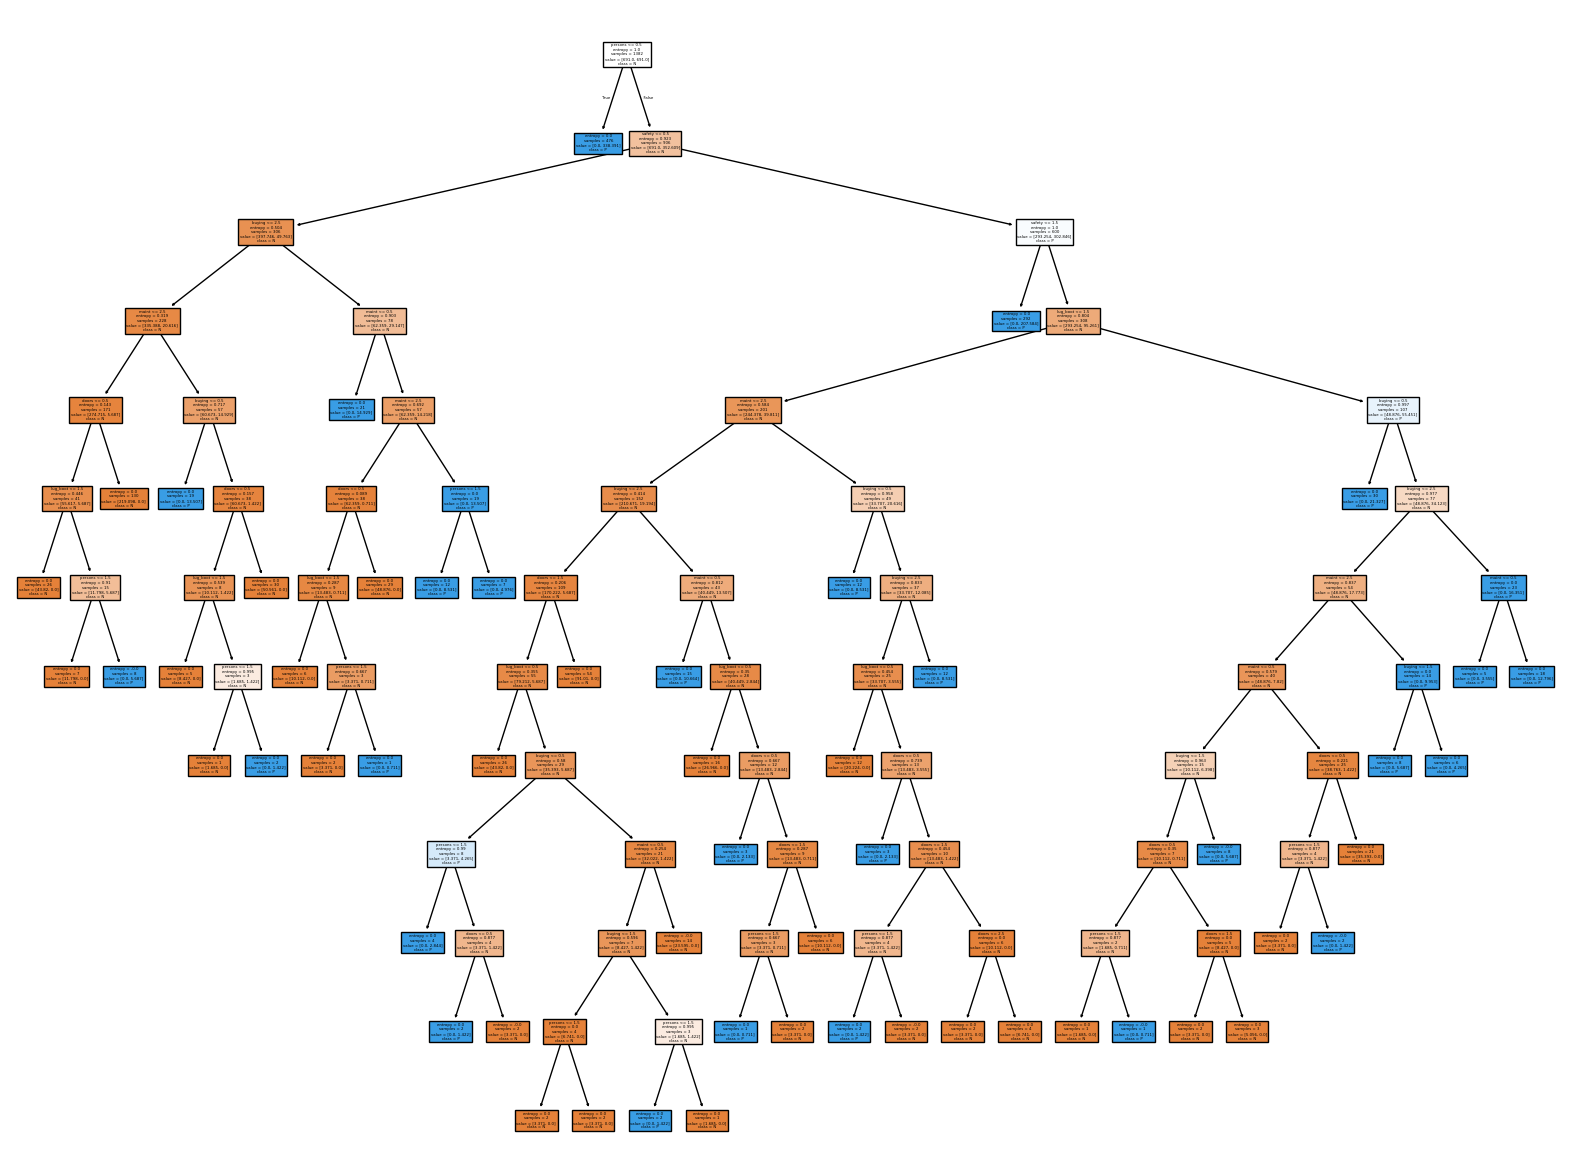

In [6]:
# Initialize and train decision tree classifier
tree_clf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', random_state=42)
tree_clf.fit(car_train_prepared, car_labels_prepared)

# Plotting the decision tree
plt.figure(figsize=(20, 15))
plot_tree(tree_clf, feature_names=car_train.columns, class_names=['N', 'P'], filled=True)
plt.show()


In [7]:
# Predictions on training data
preds_train = tree_clf.predict(car_train_prepared)

# Metrics functions
def display_metrics(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")

# Evaluate on training data
display_metrics(car_labels_prepared, preds_train)


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       410
           1       1.00      1.00      1.00       972

    accuracy                           1.00      1382
   macro avg       1.00      1.00      1.00      1382
weighted avg       1.00      1.00      1.00      1382

Confusion Matrix:
[[410   0]
 [  0 972]]


In [8]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
params_grid = {
    'max_depth': [None, 2, 3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_leaf_nodes': [None, 5, 10, 15]
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    params_grid, cv=3, verbose=1
)

# Perform grid search
grid_search.fit(car_train_prepared, car_labels_prepared)
print("Best parameters:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)


Fitting 3 folds for each of 180 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best estimator: DecisionTreeClassifier(class_weight='balanced', random_state=42)


In [9]:
# Prepare test data
car_test = test_data.drop('binaryClass', axis=1)
car_test_labels = test_data['binaryClass']

# Transform test data
car_test_prepared = pipe.transform(car_test)
car_test_labels_prepared = label_enc.transform(car_test_labels)

# Evaluate the best model on test data
best_tree = grid_search.best_estimator_
test_preds = best_tree.predict(car_test_prepared)
display_metrics(car_test_labels_prepared, test_preds)


Accuracy: 0.9971098265895953
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       108
           1       1.00      1.00      1.00       238

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

Confusion Matrix:
[[108   0]
 [  1 237]]


In [10]:
# Summary of results
print("Model performed well with hyperparameter tuning.")
print("Final Test Accuracy:", accuracy_score(car_test_labels_prepared, test_preds))


Model performed well with hyperparameter tuning.
Final Test Accuracy: 0.9971098265895953
